I was analyzing data for an online retail business that faced a common problem — many customers were becoming inactive after their first or second purchase. The business didn’t have a clear idea of who was likely to churn, which made it hard to take proactive retention steps.

My task was to build a model to predict which customers were at high risk of churn, based on their past behavior and transaction history. The goal was to help the marketing team focus on saving high-value customers before they became inactive.

I followed a structured approach:

Data Preparation: Cleaned and filtered customer transaction data by removing returns, handling missing values, and aggregating the data at the customer level.

Feature Engineering: I engineered both RFM and behavioral features, including:

Recency: Days since last purchase

Frequency: Number of purchases

Monetary value: Total spend

Product variety: Number of unique products/categories purchased

Active months: Number of months the customer was active

Active days: Number of distinct purchase days

Revenue difference: Change in spending compared to previous period

Month of last activity

Target Definition: Defined a churned customer as one who had not made a purchase in the last 6 months.

Modeling: Built and tested multiple classification models — including Logistic Regression, Random Forest, and XGBoost — to predict the churn probability.

Evaluation: Evaluated model performance using metrics like AUC-ROC, precision, and especially recall, since it was important to catch as many at-risk customers as possible.

The final churn prediction model achieved an overall accuracy of 97%, with a precision of 96% and recall of 93% for identifying churned customers.
This means the model could correctly identify most customers at risk of churn while minimizing false positives
By leveraging behavioral features like product variety, active months, active days, and revenue trends, the model became more robust and actionable
This approach has strong potential to reduce churn and increase customer lifetime value, even though the model was evaluated only on historical data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
og = pd.read_csv('og.csv')

In [3]:

def get_rfm_features_enhanced(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df = df[df['Quantity'] > 0].copy()
    
    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['InvoiceDay'] = df['InvoiceDate'].dt.date
    df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
    
    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

    rfm = df.groupby(['CustomerID', 'Country']).agg(
        Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        Frequency=('InvoiceNo', 'nunique'),
        Monetary=('TotalRevenue', 'sum'),
        ActiveMonths=('InvoiceMonth', 'nunique'),
        FirstPurchase=('InvoiceDate', 'min')
    ).reset_index()
    
    tot = rfm['Monetary'].sum()
    rfm['PCT contribution'] = (rfm['Monetary'] / tot) * 100
    
    # Customer Age (in months)
    rfm['CustomerAge_months'] = (snapshot_date - rfm['FirstPurchase']).dt.days // 30

    rfm['RecencyBucket'] = rfm['Recency'].apply(lambda x: 1 if x <= 30 else 0)

    rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1], duplicates='drop').astype(int)
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)
    rfm['A_Score'] = pd.qcut(rfm['ActiveMonths'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)

    def classify_customer_refined(row):
        if (row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4 and row['A_Score'] >= 4):
            return 'True Champions'
        elif (row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3):
            return 'Loyal Customers'
        elif row['R_Score'] <= 2 and (row['F_Score'] >= 3 or row['M_Score'] >= 3):
            return 'At-Risk Customers'
        else:
            return 'Needs Attention'
    
    rfm['classify_customer'] = rfm.apply(classify_customer_refined, axis=1)

    product_variety = df.groupby('CustomerID')['Description'].nunique().reset_index()
    product_variety.columns = ['CustomerID', 'ProductVariety']

    returns = df[df['Quantity'] < 0].groupby('CustomerID')['Quantity'].count().reset_index()
    returns.columns = ['CustomerID', 'Returns']
    total_orders = df[df['Quantity'] > 0].groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
    total_orders.columns = ['CustomerID', 'TotalOrders']
    returns_ratio = pd.merge(total_orders, returns, on='CustomerID', how='left').fillna(0)
    returns_ratio['ReturnRate'] = returns_ratio['Returns'] / returns_ratio['TotalOrders']
    returns_ratio = returns_ratio[['CustomerID', 'ReturnRate']]

    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    monthly_revenue = df.groupby(['CustomerID', 'InvoiceMonth'])['TotalRevenue'].sum().reset_index()
    monthly_revenue['RevenueDiff'] = monthly_revenue.groupby('CustomerID')['TotalRevenue'].diff()
    latest_trend = monthly_revenue.sort_values(['CustomerID', 'InvoiceMonth']).groupby('CustomerID').tail(1)
    latest_trend = latest_trend[['CustomerID', 'RevenueDiff']].fillna(0)

    daily = df.groupby(['CustomerID', 'InvoiceDay']).size().reset_index()
    daily_count = daily.groupby('CustomerID')['InvoiceDay'].nunique().reset_index()
    daily_count.columns = ['CustomerID', 'DaysActive']

    invoice_dates = df.sort_values(['CustomerID', 'InvoiceDate']).groupby('CustomerID')['InvoiceDate'].apply(list)
    def calc_variance(dates):
        if len(dates) < 2: return 0
        intervals = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
        return np.std(intervals)
    interval_std = invoice_dates.apply(calc_variance).reset_index()
    interval_std.columns = ['CustomerID', 'IntervalStd']

    final = rfm.merge(product_variety, on='CustomerID', how='left')
    final = final.merge(returns_ratio, on='CustomerID', how='left')
    final = final.merge(latest_trend, on='CustomerID', how='left')
    final = final.merge(daily_count, on='CustomerID', how='left')
    final = final.merge(interval_std, on='CustomerID', how='left')

    final.fillna(0, inplace=True)

    return final

In [9]:
final_df = get_rfm_features_enhanced(og)

In [10]:
final_df.head()

,CustomerID,Country,Recency,Frequency,Monetary,ActiveMonths,FirstPurchase,PCT contribution,CustomerAge_months,RecencyBucket,R_Score,F_Score,M_Score,A_Score,classify_customer,ProductVariety,ReturnRate,RevenueDiff,DaysActive,IntervalStd
0,12347.0,Iceland,2,6,3598.21,6,2011-01-26 14:30:00,0.046292,10,1,5,5,5,5,True Champions,87,0.0,-1069.50,6,11.688705
1,12348.0,Finland,75,3,784.44,3,2011-01-25 10:42:00,0.010092,10,0,2,3,3,4,At-Risk Customers,9,0.0,-57.00,3,53.781131
2,12349.0,Italy,19,1,1457.55,1,2011-11-21 09:51:00,0.018752,0,1,4,1,4,1,Needs Attention,72,0.0,0.00,1,0.000000
3,12350.0,Norway,310,1,294.40,1,2011-02-02 16:01:00,0.003788,10,0,1,1,2,1,Needs Attention,16,0.0,0.00,1,0.000000
4,12352.0,Norway,36,6,1265.41,4,2011-02-16 12:33:00,0.016280,9,0,3,5,4,4,Loyal Customers,57,0.0,-280.77,6,22.098365


In [11]:
ml_data = final_df.drop(columns=['CustomerID', 'R_Score', 'F_Score', 'M_Score', 'A_Score', 'ReturnRate', 'DaysActive', 'RecencyBucket', 'FirstPurchase', 'Country'])

<Axes: >

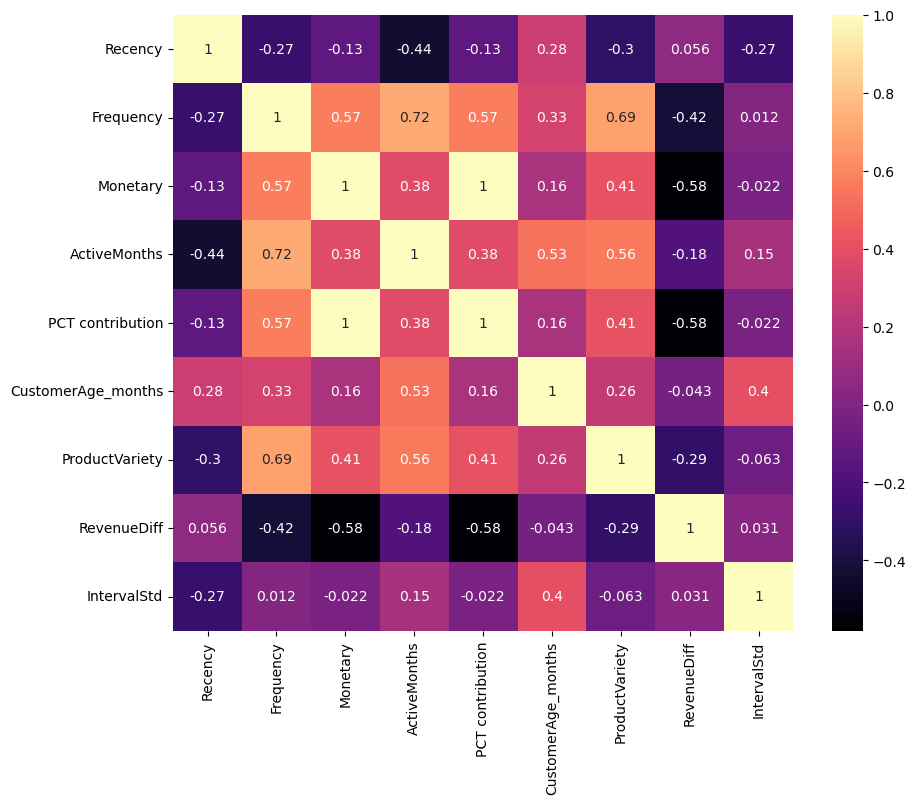

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(ml_data[ml_data.select_dtypes(include=['int64', 'float64']).columns].corr(), annot = True, cmap='magma')

In [13]:
ml_data['ischurn'] = ml_data.apply(lambda x: 1 if x['Recency'] > 90 else 0, axis=1)

In [14]:
ml_data[ml_data.select_dtypes(include=['int64', 'float64']).columns].corr()['ischurn'].sort_values(ascending=False)

ischurn               1.000000
Recency               0.868035
CustomerAge_months    0.245618
RevenueDiff           0.036701
PCT contribution     -0.107198
Monetary             -0.107198
IntervalStd          -0.218117
Frequency            -0.222629
ProductVariety       -0.262795
ActiveMonths         -0.368215
Name: ischurn, dtype: float64

In [15]:
x = ml_data.drop(columns=['ischurn'])
y = ml_data['ischurn']

In [16]:
x.drop(columns = 'Recency', inplace = True)

In [17]:
cat_columns = x.select_dtypes(include=['object']).columns
num_columns = x.select_dtypes(include=['int64', 'float64']).columns

In [18]:
print(cat_columns)
print(num_columns)

Index(['classify_customer'], dtype='object')
Index(['Frequency', 'Monetary', 'ActiveMonths', 'PCT contribution',
       'CustomerAge_months', 'ProductVariety', 'RevenueDiff', 'IntervalStd'],
      dtype='object')


<Axes: xlabel='classify_customer', ylabel='count'>

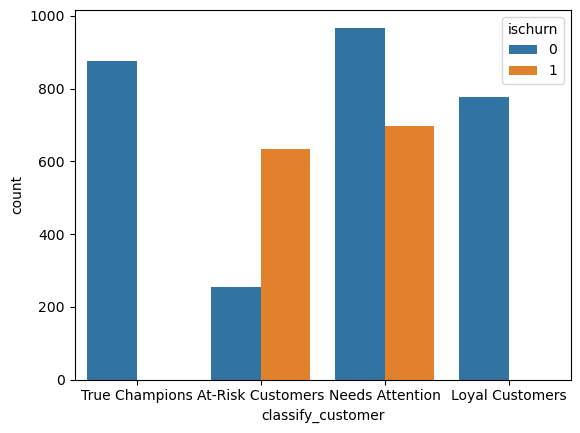

In [19]:
sns.countplot(data=ml_data, x='classify_customer', hue = 'ischurn')

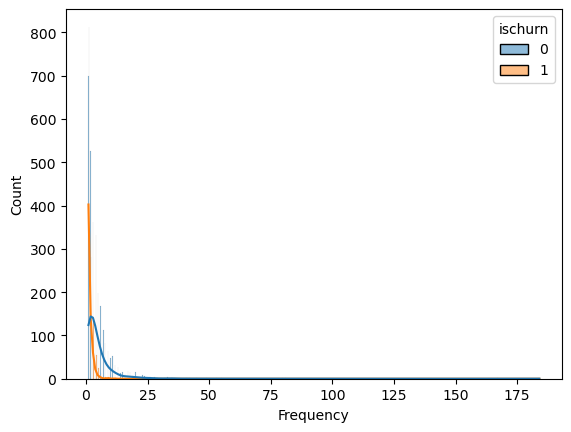

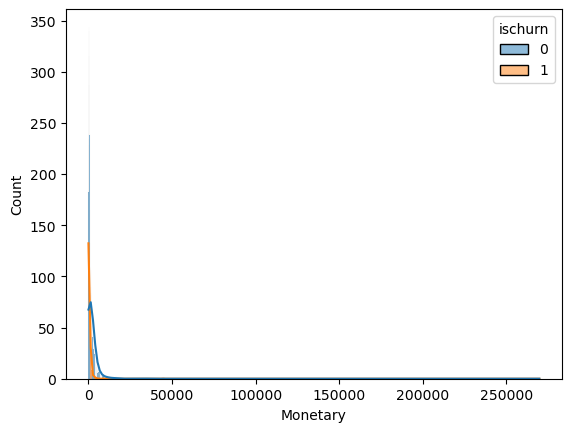

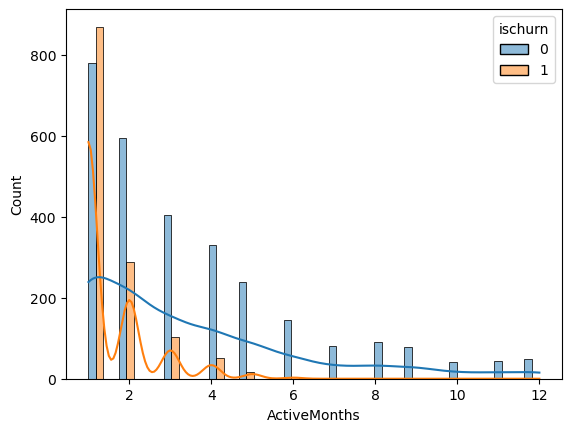

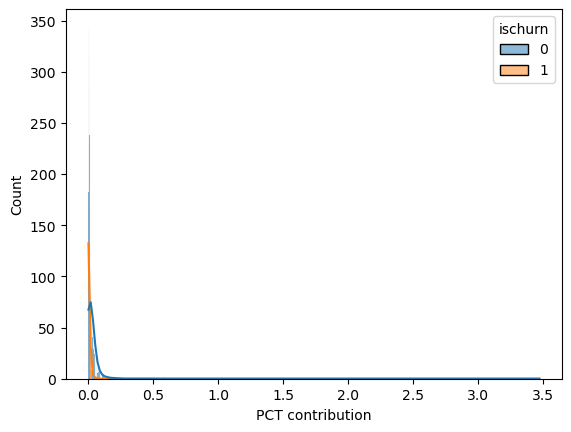

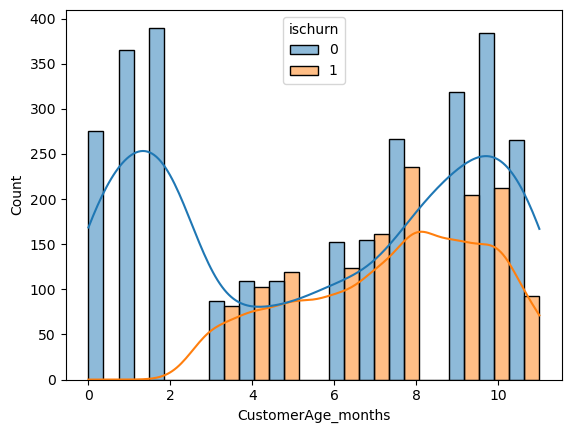

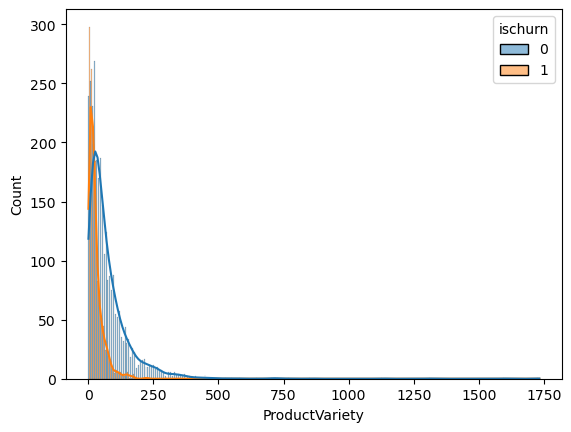

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


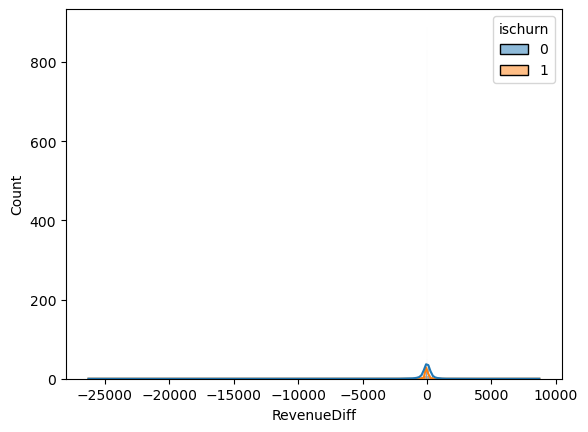

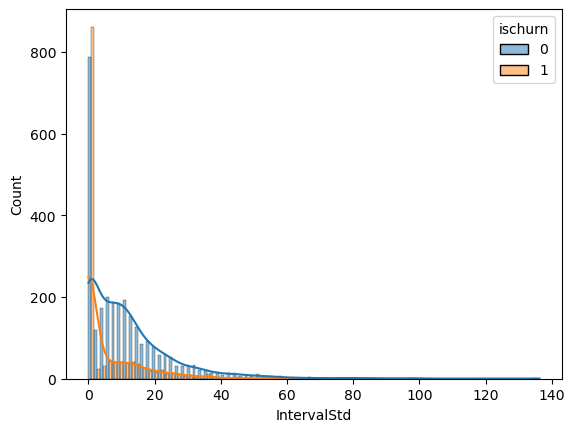

In [20]:
for i in num_columns:
  sns.histplot(data=ml_data, x=i, hue='ischurn', kde=True, multiple = 'dodge')
  plt.show()

In [21]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
x_train['classify_customer'].unique()

array(['True Champions', 'Loyal Customers', 'At-Risk Customers',
       'Needs Attention'], dtype=object)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

<Axes: xlabel='ischurn', ylabel='count'>

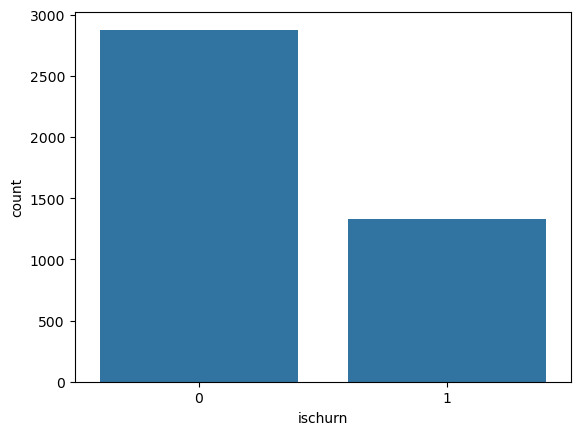

In [25]:
sns.countplot(data = ml_data, x='ischurn')

In [28]:
from sklearn.preprocessing import LabelEncoder
import pickle

label_encoder_churn = {}

for i in cat_columns:
  le = LabelEncoder()
  x_train[i] = le.fit_transform(x_train[i])
  x_test[i] = le.transform(x_test[i])
  label_encoder_churn[i] = le

with open('label_encoder_churn.pkl', 'wb') as f:
  pickle.dump(label_encoder_churn, f)

In [29]:
x_train['classify_customer'].value_counts()

classify_customer
2    1328
0     712
3     701
1     627
Name: count, dtype: int64

In [30]:
from sklearn.preprocessing import RobustScaler

scalar_churn = {}

for j in num_columns:
  robust_scaler = RobustScaler()

  x_train[j] = robust_scaler.fit_transform(x_train[[j]])
  x_test[j] = robust_scaler.transform(x_test[[j]])

  scalar_churn[j] = robust_scaler

with open('scalar_churn.pkl', 'wb') as f:
  pickle.dump(scalar_churn, f)

In [32]:
x_test.head()

,Frequency,Monetary,ActiveMonths,PCT contribution,CustomerAge_months,classify_customer,ProductVariety,RevenueDiff,IntervalStd
1073,-0.333333,-0.486592,-0.333333,-0.486592,-1.166667,2,-0.542373,0.000000,-0.426548
144,3.000000,0.802317,2.333333,0.802317,0.666667,3,0.796610,-1.486942,0.497506
2380,-0.333333,-0.210804,-0.333333,-0.210804,-1.000000,2,-0.305085,0.000000,-0.426548
184,0.000000,1.380819,0.000000,1.380819,0.666667,2,1.271186,-5.090678,1.587499
2587,0.333333,0.012449,0.333333,0.012449,-0.166667,1,-0.254237,-1.110758,1.744057


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [35]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(f'{name} Accuracy: {accuracy_score(y_test, y_pred)}')

Logistic Regression Accuracy: 0.9334916864608076
Decision Tree Accuracy: 0.9572446555819477
Random Forest Accuracy: 0.9572446555819477
SVM Accuracy: 0.9239904988123515
KNN Accuracy: 0.9501187648456056


In [36]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       569
           1       0.96      0.94      0.95       273

    accuracy                           0.97       842
   macro avg       0.96      0.96      0.96       842
weighted avg       0.97      0.97      0.97       842



In [37]:
print(confusion_matrix(y_test, y_pred))

[[557  12]
 [ 16 257]]


In [38]:
with open('rf_churn.pkl', 'wb') as f:
  pickle.dump(rf, f)

In [39]:
def predict():
  test_data = {}

  for col in x.columns:
    test_data[col] = input(f'Enter {col}: ')

  test_df = pd.DataFrame([test_data])
  test_df[num_columns] = test_df[num_columns].astype(float)

  with open('label_encoder_churn.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

  with open('scalar_churn.pkl', 'rb') as f:
    scalar = pickle.load(f)

  for i in cat_columns:
    test_df[i] = label_encoder[i].transform(test_df[i])

  for j in num_columns:
    test_df[j] = scalar[j].transform(test_df[[j]])

  with open('rf_churn.pkl', 'rb') as f:
    model = pickle.load(f)

  pred = model.predict(test_df)
  predict_proba = model.predict_proba(test_df)

  print("Predicted Label:", pred[0])
  print("Prediction Probability:", predict_proba[0])

In [40]:
#if __name__ == "__main__":
    #predict()